<a href="https://colab.research.google.com/github/srv96/AI-ML-TensorFlow/blob/main/Spam_Detection_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2025-01-22 23:32:28--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.06s   

2025-01-22 23:32:28 (8.25 MB/s) - ‘spam.csv’ saved [503663/503663]



In [4]:
df = pd.read_csv('spam.csv',encoding='ISO-8859-1')
df = df.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.columns = ['labels','data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df['b_labels'] = df['labels'].map({'ham':0,'spam':1})
Y = df['b_labels'].values

In [7]:
df_train , df_test , Ytrain , Ytest = train_test_split(df['data'],Y,test_size=0.33)

In [99]:
train_dataset = tf.data.Dataset.from_tensor_slices((df_train.values,Ytrain))
test_dataset = tf.data.Dataset.from_tensor_slices((df_test.values,Ytest))

In [100]:
MAX_VOCAB_SIZE = 20_000
vectorization = tf.keras.layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
)
vectorization.adapt(train_dataset.map(lambda x , y : x))

In [101]:
train_dataset = train_dataset.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [102]:
V = len(vectorization.get_vocabulary())
print(V)

7647


In [104]:
#embedding dimension
D = 20

#hidden state dimension
M = 15

#if string not specified
i = tf.keras.layers.Input(shape=(1,),dtype = tf.string)
x = vectorization(i)
x = tf.keras.layers.Embedding(V,D)(x)
x = tf.keras.layers.LSTM(M,return_sequences=True)(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(i,x)

In [105]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [106]:
r = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = 10
)

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8187 - loss: 0.5579 - val_accuracy: 0.8809 - val_loss: 0.3256
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8801 - loss: 0.2824 - val_accuracy: 0.9701 - val_loss: 0.1309
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9869 - loss: 0.0862 - val_accuracy: 0.9761 - val_loss: 0.0886
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9904 - loss: 0.0517 - val_accuracy: 0.9799 - val_loss: 0.0734
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9961 - loss: 0.0345 - val_accuracy: 0.9793 - val_loss: 0.0734
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9946 - loss: 0.0321 - val_accuracy: 0.9782 - val_loss: 0.0749
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9973 - loss: 0.0185 - val_accuracy: 0.9810 - val_loss: 0.0738
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9982 - loss: 0.0144 - val_accu

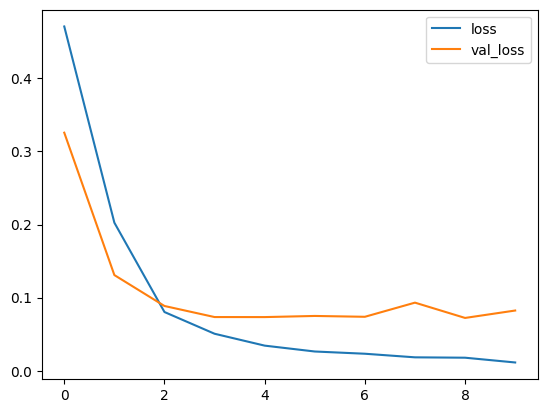

In [107]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

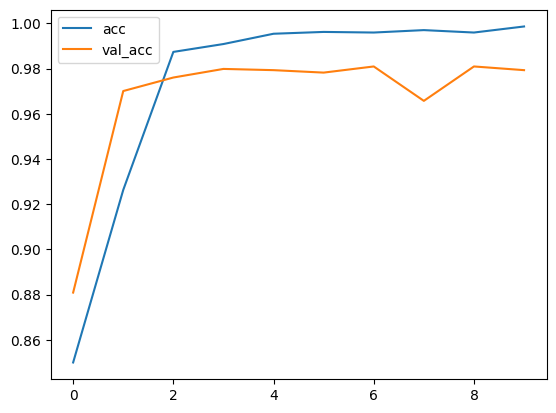

In [108]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

<Axes: >

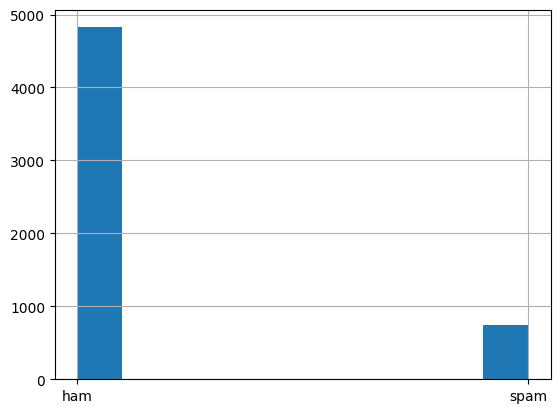

In [109]:
df['labels'].hist() #checking for class imbalance

In [110]:
from sklearn.metrics import f1_score
f1_score(Ytrain, model.predict(df_train.values) > 0.5)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


0.9971509971509972

In [111]:
f1_score(Ytest, model.predict(df_test.values) > 0.5)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


0.9147982062780269

## # converting string to number everytime during training is not feasible so do it once and store it , string take less space then string

In [8]:
df_train , df_test , Ytrain , Ytest = train_test_split(df['data'],Y,test_size=0.33)

In [11]:
MAX_VOCAB_SIZE = 20_000
vectorization_layers_ragged = tf.keras.layers.TextVectorization(
    max_tokens = MAX_VOCAB_SIZE,
    ragged = True,
    output_mode = 'int'
)
vectorization_layers_ragged.adapt(df_train)

In [12]:
train_sequence = vectorization_layers_ragged(df_train.values).numpy()
test_sequence = vectorization_layers_ragged(df_test.values).numpy()

In [13]:
train_sequence_pad = tf.keras.preprocessing.sequence.pad_sequences(train_sequence, padding='pre')
test_sequence_pad = tf.keras.preprocessing.sequence.pad_sequences(test_sequence, padding='pre')

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequence_pad, Ytrain))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sequence_pad, Ytest))

batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
#embedding features
V = len(vectorization_layers_ragged.get_vocabulary())

#embedding dimension
D = 20

#hidden state dimension
M = 25

T = train_sequence_pad.shape[1]
D = 1

#if string not specified
i = tf.keras.layers.Input(shape=(None,),dtype = tf.int32)
x = tf.keras.layers.Embedding(V,D)(i)
x = tf.keras.layers.LSTM(M,return_sequences=True)(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(i,x)

In [16]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [17]:
r = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = 15
)

Epoch 1/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8618 - loss: 0.5227 - val_accuracy: 0.8722 - val_loss: 0.3582
Epoch 2/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8727 - loss: 0.3464 - val_accuracy: 0.8722 - val_loss: 0.3275
Epoch 3/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8545 - loss: 0.3422 - val_accuracy: 0.8722 - val_loss: 0.3023
Epoch 4/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8669 - loss: 0.2962 - val_accuracy: 0.8722 - val_loss: 0.2603
Epoch 5/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8636 - loss: 0.2604 - val_accuracy: 0.9418 - val_loss: 0.2075
Epoch 6/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9648 - loss: 0.1880 - val_accuracy: 0.9647 - val_loss: 0.1641
Epoch 7/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9790 - loss: 0.1376 - val_accuracy: 0.9728 - val_loss: 0.1286
Epoch 8/15
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9880 - loss: 0.1033 - val_accurac

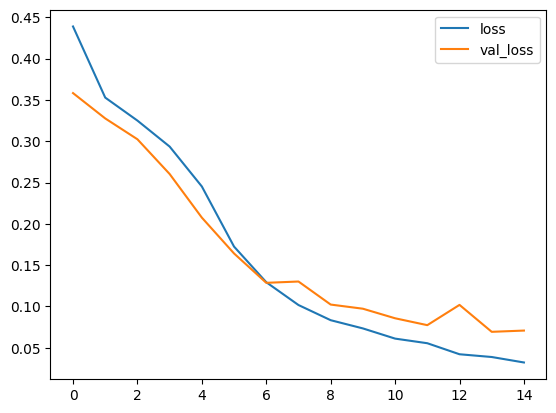

In [18]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

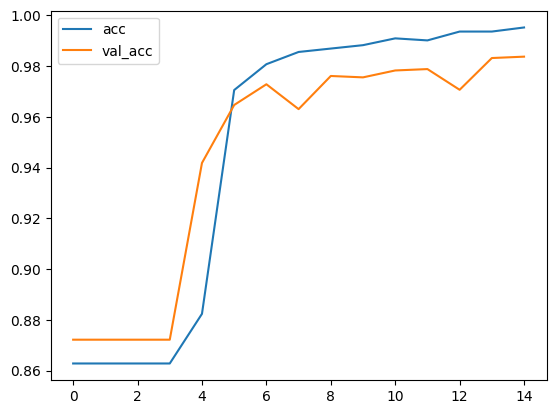

In [19]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()